## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

d:\Programs\anac\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре. 

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [2]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [3]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
1318810,916595,14378,100,7957,100.0
2948660,928925,1418,111,1010,19.0
2679518,425497,11382,108,10254,100.0
3851233,30029,3734,106,6809,100.0
1890517,512041,13865,108,8590,100.0


Сделаем разбиение по времени

<Axes: >

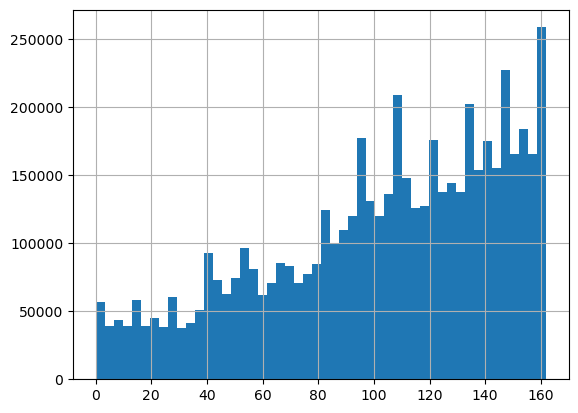

In [4]:
df.last_watch_dt.hist(bins=50)

In [5]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [6]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [7]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [8]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
33,68478,9728,151,139,2.0
87,379585,9070,151,2301,35.0
114,806082,579,110,836,11.0
189,969875,372,122,567,12.0
234,20224,8650,102,154,3.0


In [9]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

C:\Users\DARYA\AppData\Local\Temp\ipykernel_4700\1105526701.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
C:\Users\DARYA\AppData\Local\Temp\ipykernel_4700\1105526701.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,120,"[(15297, 151), (6809, 151), (1000, 151)]"
1,170,"[(13237, 152), (4331, 152)]"
2,189,"[(5505, 144)]"
3,313,"[(14170, 4), (162, 4), (8276, 6), (758, 14), (..."
4,480,"[(7389, 51), (9314, 51), (760, 55), (9709, 56)..."


In [10]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,120,"[(15297, 151), (6809, 151), (1000, 151)]","[(10440, 157), (13865, 157)]"
1,170,"[(13237, 152), (4331, 152)]","[(1453, 153), (741, 154), (15679, 154), (11083..."
2,189,"[(5505, 144)]","[(12360, 155), (6898, 155), (4549, 160), (582,..."
3,313,"[(14170, 4), (162, 4), (8276, 6), (758, 14), (...","[(9062, 156)]"
4,480,"[(7389, 51), (9314, 51), (760, 55), (9709, 56)...","[(7025, 161)]"


In [11]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=10)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,120,"[(15297, 151), (6809, 151), (1000, 151)]","[(10440, 157), (13865, 157)]","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1..."
1,170,"[(13237, 152), (4331, 152)]","[(1453, 153), (741, 154), (15679, 154), (11083...","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1..."
2,189,"[(5505, 144)]","[(12360, 155), (6898, 155), (4549, 160), (582,...","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1..."
3,313,"[(14170, 4), (162, 4), (8276, 6), (758, 14), (...","[(9062, 156)]","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1..."
4,480,"[(7389, 51), (9314, 51), (760, 55), (9709, 56)...","[(7025, 161)]","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1..."


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$. 

In [12]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):

    if topn is None:
        topn = len(predictions)
    else:
        topn = min(topn, len(predictions))

    checking = []
    for p in predictions[:topn]:
        if p in gt_items:
            checking.append(1)
        else:
            checking.append(0)
    
    sum_el = 0
    index = 1
    for p in checking:
        sum_el += p * (1./index) * sum(checking[:index])
        index += 1
        


    return 1. / min(topn, len(gt_items)) * sum_el

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):

    
    if topn is None:
        topn = len(predictions)
    else:
        topn = min(topn, len(predictions))

    for i in range(1, topn + 1):
        if predictions[i-1] in gt_items:
            return 1. / i 
        
    return 0

def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):

    if topn is None:
        topn = len(predictions)
    else:
        topn = min(topn, len(predictions))

    if len(set(gt_items) & set(predictions[:topn])) > 0:
        return 1
    
    return 0


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит. 

In [13]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать. 

In [14]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [15]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.001022595238095238, 'mrr': 0.003844444444444444, 'hr': 0.0084}

In [16]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,120,"[(15297, 151), (6809, 151), (1000, 151)]","[(10440, 157), (13865, 157)]","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
1,170,"[(13237, 152), (4331, 152)]","[(1453, 153), (741, 154), (15679, 154), (11083...","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
2,189,"[(5505, 144)]","[(12360, 155), (6898, 155), (4549, 160), (582,...","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
3,313,"[(14170, 4), (162, 4), (8276, 6), (758, 14), (...","[(9062, 156)]","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
4,480,"[(7389, 51), (9314, 51), (760, 55), (9709, 56)...","[(7025, 161)]","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [17]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06522589663643234, 'mrr': 0.11736071428571426, 'hr': 0.2716}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [18]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        counts = {}
        time_max = -1
        for _, row in df.iterrows():
            for item, time in row[col]:
                if time > time_max:
                    time_max = time
                    
                if item in counts:
                    counts[item].append(time)
                else:
                    counts[item] = [time]

        min_time_in_window = time_max - self.min_window

        remove_k = []

        for key in counts.items():
            item = key[0]
            counts[item] = len([i for i in counts[item] if i >=min_time_in_window])

            if counts[item] == 0:
                remove_k.append(item)

        for i in remove_k:
            counts.pop(i)

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True
    
    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)
        
        


Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна. 

In [19]:
window_size = range(1, 100, 5)

dfw = pd.DataFrame({'window':[], 'map':[], 'mrr':[], 'hr':[]})

for i in window_size:
    toppop_wind = TopPopularWeighted(i)
    toppop_wind.fit(joined)
    joined['toppopular_wind_recs'] = toppop_wind.predict(joined)

    res = evaluate_recommender(joined, model_preds='toppopular_wind_recs')
    dfw.loc[i] = [i, res['map'], res['mrr'], res['hr']]

print(dfw.head())

    window       map       mrr      hr
1      1.0  0.070068  0.127180  0.3042
6      6.0  0.071317  0.128567  0.3142
11    11.0  0.071040  0.128073  0.3127
16    16.0  0.070897  0.127873  0.3127
21    21.0  0.068804  0.125682  0.2865


d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a futur

<Axes: xlabel='window', ylabel='value'>

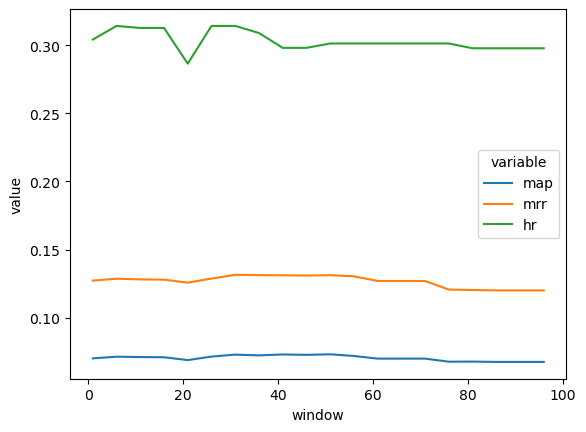

In [20]:
import seaborn as sns

dff = pd.melt(dfw, ['window'])
sns.lineplot(data=dff, x='window', y='value', hue='variable')



In [21]:
df.describe()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
count,5.476250e+06,5.476250e+06,5.476250e+06,5.476250e+06,5.475422e+06
mean,5.491159e+05,8.485861e+03,1.024973e+02,8.295491e+03,4.637400e+01
std,3.166077e+05,4.740762e+03,4.281572e+01,4.856800e+04,4.191853e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.750140e+05,4.326000e+03,7.300000e+01,3.710000e+02,4.000000e+00
50%,5.493640e+05,8.776000e+03,1.100000e+02,2.898000e+03,3.200000e+01
75%,8.227540e+05,1.254400e+04,1.390000e+02,7.116000e+03,1.000000e+02
max,1.097557e+06,1.651800e+04,1.620000e+02,8.041167e+07,1.000000e+02


Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:** 
MAP - дает максимальное усредненное значение при окне = 1, далее метрика уменьшается и на значениях с 36 по 61 график растет и снова падает.
MRR - с 16 по 21 значения метрика резко возрастает и до значения 76 метрика слегка уменьшается с небольшими единичными резкими повышениями.
MHR - при увеличении значения окна метрика уменьшается. 

Если нам важны все 3 метрики, то лучше взять значение окна равного 51 - это первое значение окна после среднего и по нему значения метрик будет близко к среднему. Если нам важна метрика MHR, то лучше брать как можно меньшее значение. Для других метрик окно должно быть равно от 30 до 60. 

In [22]:
toppop_wind = TopPopularWeighted(51)
toppop_wind.fit(joined)
joined['toppopular_wind_recs'] = toppop_wind.predict(joined)

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике. 

In [23]:
topk = range(1, 100, 5)

df1 = pd.DataFrame({'top-K':[], 'map':[], 'mrr':[], 'hr':[]})

for i in topk:
    joined['toppopular_recs'] = toppop.predict(joined, topn=i)

    res = evaluate_recommender(joined, model_preds='toppopular_recs')
    df1.loc[i] = [i, res['map'], res['mrr'], res['hr']]

print(df1.head())
joined['toppopular_recs'] = toppop.predict(joined, topn=10)


    top-K       map       mrr      hr
1     1.0  0.049800  0.049800  0.0498
6     6.0  0.063443  0.113602  0.2402
11   11.0  0.065507  0.117933  0.2779
16   16.0  0.069179  0.122734  0.3399
21   21.0  0.070581  0.124300  0.3709


d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a futur

<Axes: xlabel='top-K', ylabel='value'>

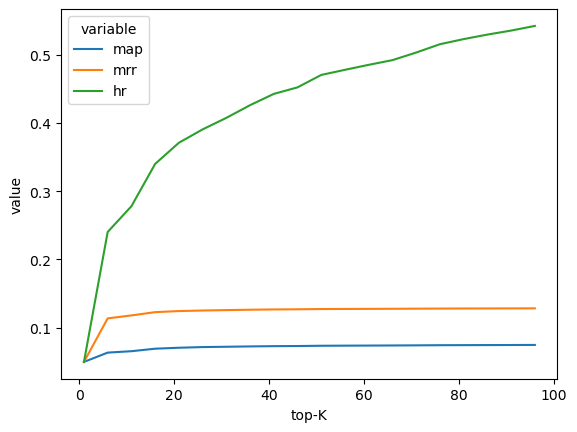

In [24]:
dfl = pd.melt(df1, ['top-K'])
sns.lineplot(data=dfl, x='top-K', y='value', hue='variable')

In [25]:
df1.describe()

,top-K,map,mrr,hr
count,20.000000,20.000000,20.000000,20.000000
mean,48.500000,0.071095,0.121877,0.423520
std,29.580399,0.005855,0.017375,0.121994
min,1.000000,0.049800,0.049800,0.049800
25%,24.750000,0.071304,0.124924,0.385600
50%,48.500000,0.073285,0.127099,0.461200
75%,72.250000,0.074137,0.127855,0.506150
max,96.000000,0.074687,0.128291,0.542100


Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:** Все метрики являются возрастающими монотонными функциями по top-K. top-k - параметр, который отвечает за количество айтемов в рейтинге популярности. Чем он больше, тем больше популярных айтемом мы ищем в "подборках" айтемов, с которыми повзаимодействовал пользователи, и тем выше вероятность, что юзеры взаимодействовали с ними.

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:** HR - чем больше популярных новостей мы поместим в ленту к пользователям, тем больше пользователей лайкнет или откроет интересующую его новость. MAP и MRR - добавление в ленту к пользователям до 15 самых популярных новостей может сильно увлечь пользователей и заставит их повзаимодействовать с новостью. Если добавлять больше новостей из рейтинга, то это уже не так сильно увлечет его.

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:** Так как top-K - параметр отвечающий за топ самых популярных айтемов, а популярность - кол-во взаимодействий пользователей с айтемов, то в нашем случае графики должны увеличиваться. Чтобы айтем стал популярным, много пользователей должны прореагировать на него. 
Кроме популярности айтемов, графики еще зависят от кол-во юзеров по которым усреднялась метрика. Мы могли взять 1 юзера с его новостями. И дать почитать его ленту другому человеку с другими интересами. В таком случае вероятность, что второму что-то понравится - очень мал. А если мы будем давать читать эту ленту и другим пользователям и усреднять ее, то метрики будут падать. 
Также важно когда айтем появился и на каких пользователям проверяются данные - айтем мог появиться в последнюю секунду валидации или наоборот, перестать продаваться в последний момент train до валидации.

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей. 

In [26]:
items = pd.read_csv('items.csv')[['item_id','title', 'release_year']].copy()
items.head()

,item_id,title,release_year
0,10711,Поговори с ней,2002.0
1,2508,Голые перцы,2014.0
2,10716,Тактическая сила,2011.0
3,7868,45 лет,2015.0
4,16268,Все решает мгновение,1978.0


In [27]:
items.describe()

,item_id,release_year
count,15963.000000,15865.000000
mean,8268.453424,2007.932241
std,4773.841513,16.881118
min,0.000000,1897.000000
25%,4141.500000,2007.000000
50%,8266.000000,2014.000000
75%,12414.500000,2018.000000
max,16518.000000,2021.000000


In [28]:
items[items['release_year']==2021]

,item_id,title,release_year
70,4547,КION. Презентация онлайн-кинотеатра. 19 апреля...,2021.0
78,2662,Пакт,2021.0
87,1314,КТО ТЫ?!,2021.0
88,10519,Кто поймал букет невесты,2021.0
90,9821,Шпагат с нуля,2021.0
...,...,...,...
15709,13261,Цветняшки,2021.0
15758,5906,Райя и последний дракон,2021.0
15828,2824,Три шага к рельефу,2021.0
15944,5978,Преступление века,2021.0


Пример:

1917


<Axes: >

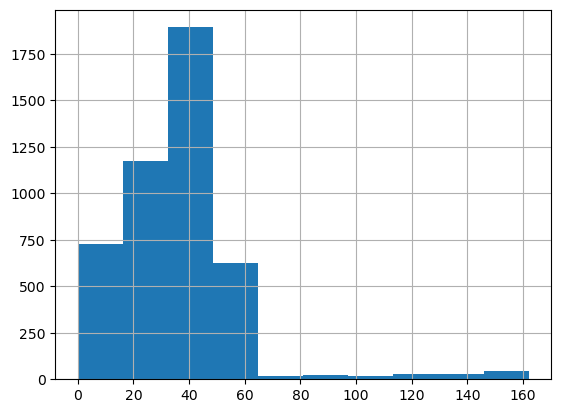

In [29]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной. 

Добавьте 5 своих примеров ниже. Опишите, как вы их искали. 

Патруль: По законам улиц


<Axes: >

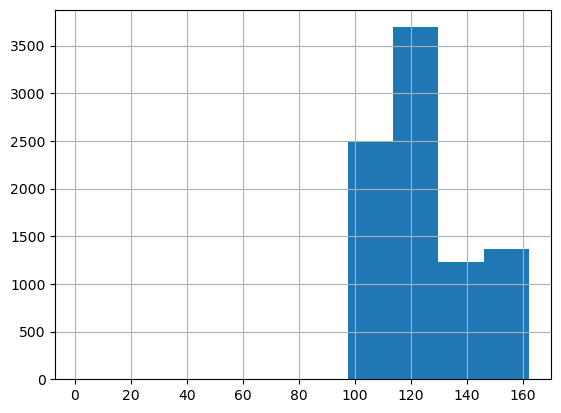

In [30]:
sampled_id = 12324

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм "Патруль: По законам улиц" вышел в 2020 году. Он резко набрал популярность в год выхода, а потом пошел на спад. - Нашла его через поиск по году.

Бережный фитнес


<Axes: >

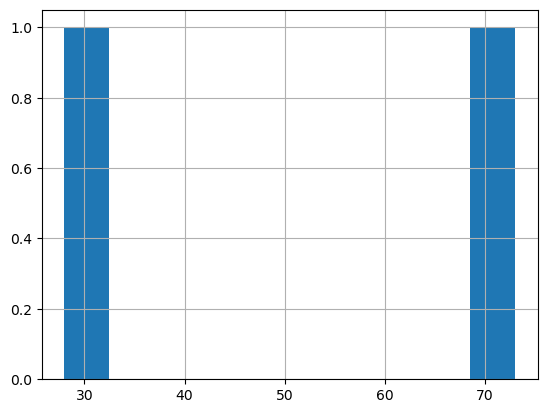

In [31]:
sampled_id = 4407

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм "Бережный фитнес" вышел в 2021 году. В нем содержится набор различных тренировок. Это не очень вовлекает людей, поэтому его до сбора данных посмотрело всего 2 человека. Нашла по фильтрации через год.

Поли


<Axes: >

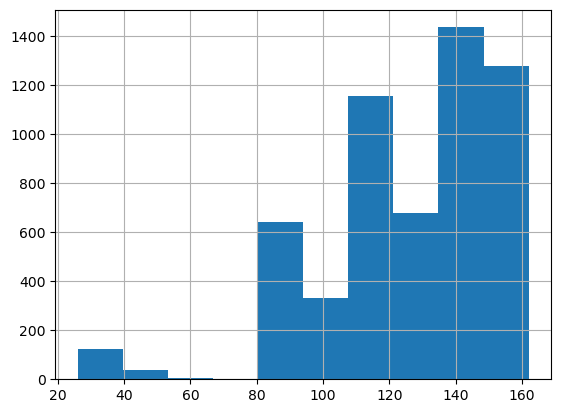

In [32]:
sampled_id = 12537

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм "Поли" вышел в 2020 году. Сначала он никого не заинтересовал, но возможно потом начались рекламные акции и больше людей посмотрели его. Нашла его через случайный поиск.

Любовь между строк


<Axes: >

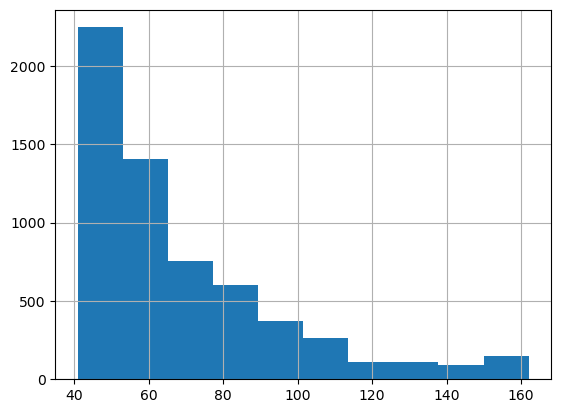

In [33]:
sampled_id = 8373

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм "Любовь между строк" вышел в 2019 году. Сначала он был очень популярен, но потом его стали меньше смотреть. Нашла его через случайный поиск.

Тайное влечение


<Axes: >

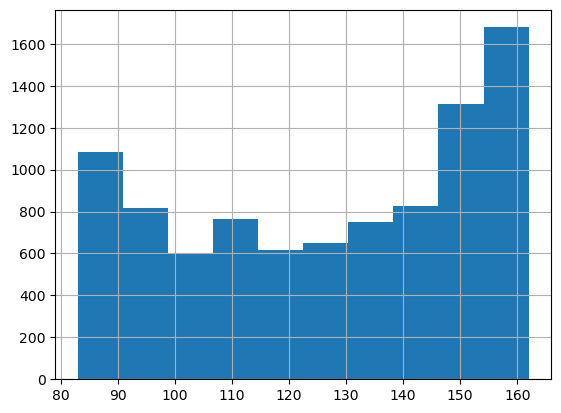

In [34]:
sampled_id = 5732

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм "Тайное влечение" вышел в 2013 году. Сначала его посмотрели достаточно много людей, позже популярность просела, а потом она снова увеличилась. Он снят в популрных жанрах и с хорошим рейтингом, поэтому это могло повлиять на его просмотры.

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках. 

In [35]:
def filter_column(df, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    users = df.value_counts('user_id', ascending=True)
    users = users[users.ge(min_freq)].index

    items = df.value_counts('item_id', ascending=True)
    items = items[items.ge(min_freq)].index

    df = df[(df['user_id'].isin(users)) & (df['item_id'].isin(items))].copy()

    return df

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    check = False
    while(not check):
        df = filter_column(df, 5)
        check = True
        for i in cols:
            if df.value_counts(i, ascending=True).iloc[0] < min_freq:
                check = False
                break

    return df.copy()

filtered_train = filter_dataframe(df, ['user_id', 'item_id'])
print(filtered_train.value_counts('user_id', ascending=True))
print(filtered_train.value_counts('item_id', ascending=True))

user_id
377371       5
828605       5
828594       5
828586       5
828585       5
          ... 
400913     571
409259     625
11526      674
555233     685
416206    1252
Name: count, Length: 302205, dtype: int64
item_id
3762          5
14544         5
13633         5
11073         5
15738         5
          ...  
4151      60114
13865     79726
9728      83407
15297     94669
10440    100134
Name: count, Length: 10031, dtype: int64


In [36]:
filtered_train.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,59,4250,72.0
1,699317,1659,77,8317,100.0
3,864613,7638,114,14483,100.0
5,1032142,6686,61,11286,100.0
6,1016458,354,154,1672,25.0


In [37]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}
    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df, item2id, id2item

filtered_train, item2id, id2item = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
4498508,49103,147,80,26399,100.0
2197579,6429,436,99,294,6.0
2979185,150569,32,128,16,0.0
678481,217230,488,157,1635,23.0
3105343,250288,160,141,474,5.0


In [38]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(filtered_train.user_id.unique()), len(filtered_train.item_id.unique())),
)
matrix

<COOrdinate sparse matrix of dtype 'float64'
	with 4278492 stored elements and shape (302205, 10031)>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра. 

In [39]:
min_freq = [1,2,3,4,5]

df_freq = pd.DataFrame({'min_freq':[], 'users':[], 'items':[]})
filt_df = df.copy()

for freq in min_freq:
    filt_df = filter_dataframe(filt_df, ['user_id', 'item_id'], freq)
    df_freq.loc[freq] = [freq, len(filt_df.user_id.unique()), len(filt_df.item_id.unique())]

print(df_freq.head())

   min_freq   users  items
1         1  302486  10348
2         2  302256  10048
3         3  302206  10036
4         4  302206  10031
5         5  302205  10031


d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a futur

<Axes: xlabel='min_freq', ylabel='value'>

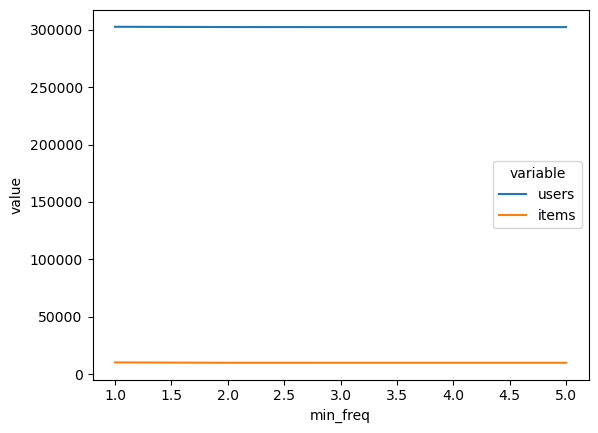

In [40]:
df_freq_plot = pd.melt(df_freq, ['min_freq'])
sns.lineplot(data=df_freq_plot, x='min_freq', y='value', hue='variable')

d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='min_freq', ylabel='users'>

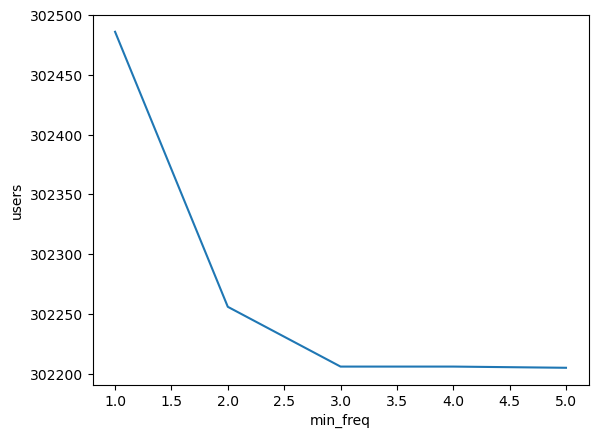

In [41]:
sns.lineplot(data=df_freq[['min_freq', 'users']], x='min_freq', y='users')

d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='min_freq', ylabel='items'>

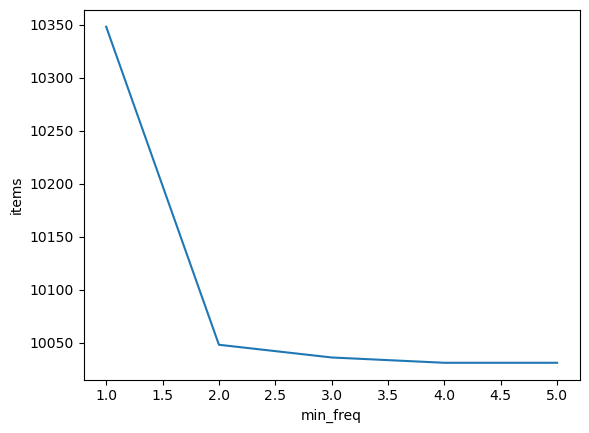

In [42]:
sns.lineplot(data=df_freq[['min_freq', 'items']], x='min_freq', y='items')

При min_freq >= 6 фильтрация занимает очень большое время (при работе 640 минут, фильтрация так и не завершилась).
Число айтемов и юзеров уменьшается при увеличении min_freq.

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k. 

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [43]:
import scipy.sparse as sp

In [44]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=1000):
     # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sp.identity(G.shape[0]).astype(np.float32)

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.0)
    return B

w = fit_ease(matrix)

CPU times: total: 1min 23s
Wall time: 34.7 s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [45]:
def get_preds(x, item2id, id2item, w, n = 10):

    user_iteraction = [t[0] for t in x]
    encoded = [item2id[t] for t in user_iteraction if t in item2id]
    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]
    preds[encoded == 1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:n]

    return decoded


joined['ease_recs'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_wind_recs,ease_recs
0,120,"[(15297, 151), (6809, 151), (1000, 151)]","[(10440, 157), (13865, 157)]","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[4151, 10440, 9728, 142, 12192, 4740, 13865, 2..."
1,170,"[(13237, 152), (4331, 152)]","[(1453, 153), (741, 154), (15679, 154), (11083...","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[12455, 2599, 1978, 13959, 14120, 12225, 3678,..."
2,189,"[(5505, 144)]","[(12360, 155), (6898, 155), (4549, 160), (582,...","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[14899, 7597, 13849, 6162, 12356, 13464, 16415..."
3,313,"[(14170, 4), (162, 4), (8276, 6), (758, 14), (...","[(9062, 156)]","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[4151, 10440, 15297, 4927, 1844, 3734, 12192, ..."
4,480,"[(7389, 51), (9314, 51), (760, 55), (9709, 56)...","[(7025, 161)]","[14119, 2025, 10442, 46, 11092, 2798, 15227, 1...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[10440, 9728, 3734, 15297, 12173, 4880, 2954, ..."


In [46]:
for col in ['random_recs', 'toppopular_recs', 'toppopular_wind_recs', 'ease_recs']:
    res = evaluate_recommender(joined, model_preds=col)
    print(f"Для метода {col[:-5]}: MAP = {round(res['map'], 5)}, MRR = {round(res['mrr'], 5)}, HR = {round(res['hr'], 5)}")


Для метода random: MAP = 0.00102, MRR = 0.00384, HR = 0.0084
Для метода toppopular: MAP = 0.06523, MRR = 0.11736, HR = 0.2716
Для метода toppopular_wind: MAP = 0.07307, MRR = 0.13119, HR = 0.3013
Для метода ease: MAP = 0.07437, MRR = 0.13784, HR = 0.3092


Сделайте выводы — какой алгоритм работает лучше?

**Ответ:** Лучше всех работает метод Рекомендаций в окне - у него самые большие значения метрик. Далее методы по убыванию - рекомендовать самые популярные айтемы, рандомные айтемы, метод EASE.

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации. 

In [47]:
weights = [10**i for i in range(0, 11, 1)]
b = [int(i*0.5) for i in weights[1:]]
weights = weights + b
weights.sort()

df_weights = pd.DataFrame({'weight':[], 'map':[], 'mrr':[], 'hr':[]})
j = joined.copy()

for i in weights:
    print(i)
    w = fit_ease(matrix, i)
    j['ease_r'] = j.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w))

    res = evaluate_recommender(j, model_preds='ease_r')
    df_weights.loc[i] = [i, res['map'], res['mrr'], res['hr']]

print(df_weights.head())


1
5
10
50
100
500
1000
5000
10000
50000
100000
500000
1000000
5000000
10000000
50000000
100000000
500000000
1000000000
5000000000
10000000000
     weight       map       mrr      hr
1       1.0  0.076111  0.140637  0.3228
5       5.0  0.075618  0.140142  0.3223
10     10.0  0.075292  0.139676  0.3206
50     50.0  0.074358  0.137932  0.3161
100   100.0  0.074380  0.138179  0.3154


d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a futur

<Axes: xlabel='weight', ylabel='value'>

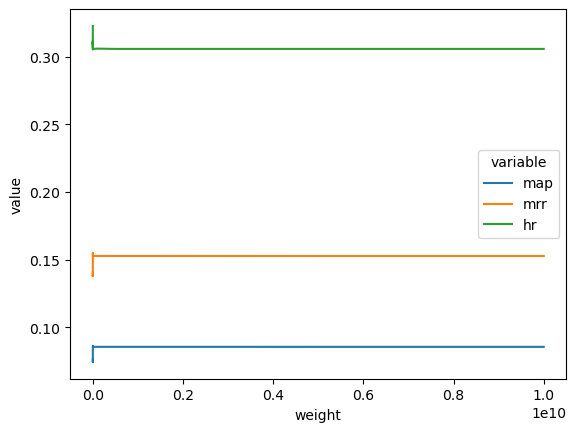

In [48]:
df_w = pd.melt(df_weights, ['weight'])
sns.lineplot(data=df_w, x='weight', y='value', hue='variable')

d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='weight', ylabel='map'>

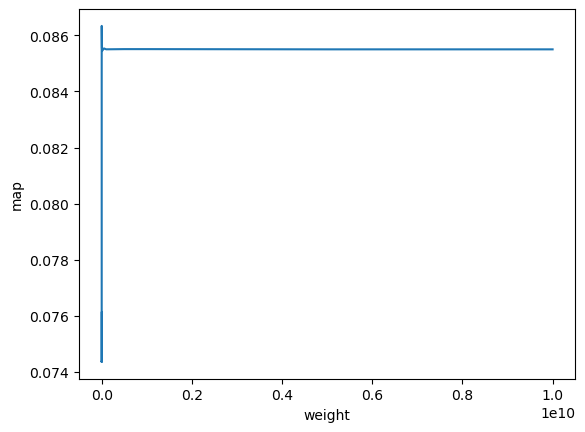

In [49]:
sns.lineplot(data=df_weights[['weight', 'map']], x='weight', y='map')

d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='weight', ylabel='map'>

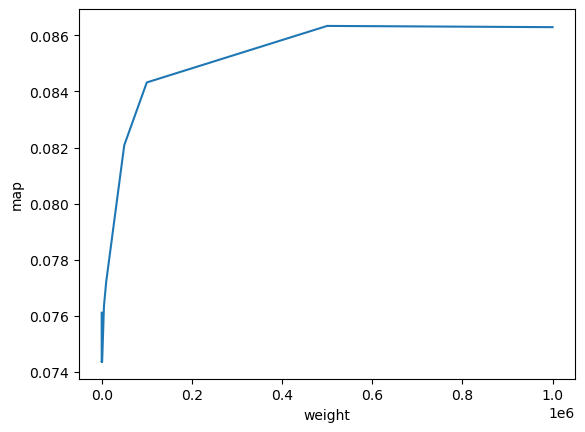

In [50]:
sns.lineplot(data=df_weights[['weight', 'map']][:13], x='weight', y='map')

d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='weight', ylabel='mrr'>

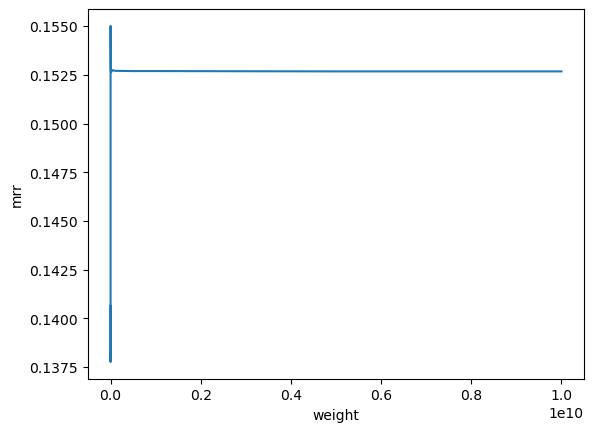

In [51]:
sns.lineplot(data=df_weights[['weight', 'mrr']], x='weight', y='mrr')

d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='weight', ylabel='mrr'>

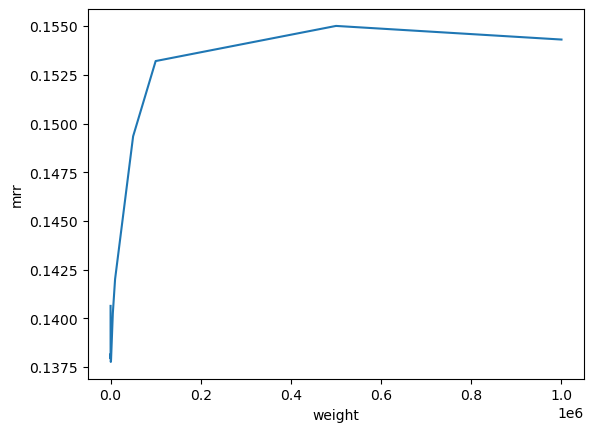

In [52]:
sns.lineplot(data=df_weights[['weight', 'mrr']][:13], x='weight', y='mrr')

d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='weight', ylabel='hr'>

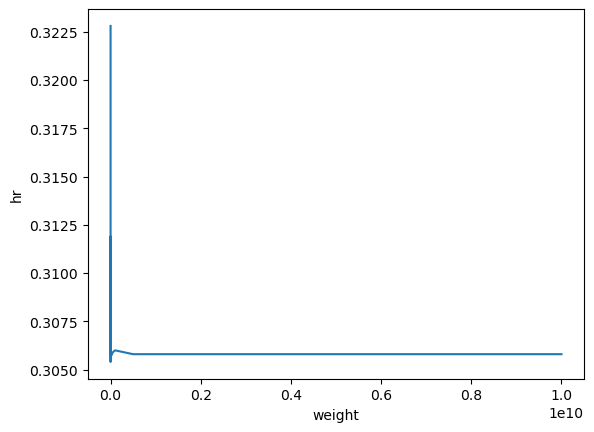

In [53]:
sns.lineplot(data=df_weights[['weight', 'hr']], x='weight', y='hr')

d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='weight', ylabel='hr'>

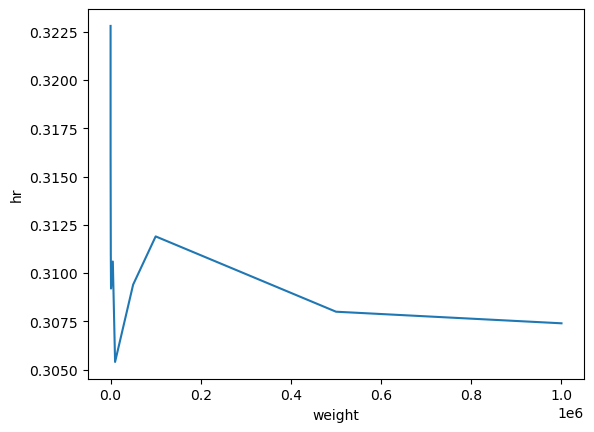

In [54]:
sns.lineplot(data=df_weights[['weight', 'hr']][:13], x='weight', y='hr')

In [55]:
df_weights

,weight,map,mrr,hr
1,1.000000e+00,0.076111,0.140637,0.3228
5,5.000000e+00,0.075618,0.140142,0.3223
10,1.000000e+01,0.075292,0.139676,0.3206
50,5.000000e+01,0.074358,0.137932,0.3161
100,1.000000e+02,0.074380,0.138179,0.3154
500,5.000000e+02,0.074356,0.137760,0.3110
1000,1.000000e+03,0.074366,0.137842,0.3092
5000,5.000000e+03,0.076346,0.140256,0.3106
10000,1.000000e+04,0.077214,0.142009,0.3054
50000,5.000000e+04,0.082080,0.149343,0.3094


Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим? 


**Ответ:** Метрики MAP и MRR достигают лучшего результата при весе равном 500000 (MAP = 0.082773, MRR = 0.150588). HR достигает маклимального значения с весом равном 1. Если нам важно, чтобы в рекомендациях, пользователя был хотя бы 1 релевантный айтем, то можно использовать вес = 1, но если нам важны другие метрики, то лучше использовать вес равный 500000

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:** После определенного значения (500000000) гиперпараметра метрики перестают изменяться. До значения 500000 метрики активно изменяются (MAP, MRR растут, HR падает), после - изменения небольшие.

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы. 

In [56]:
train_grouped = filtered_train.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

joined_f = train_grouped.merge(test_grouped)
joined_f.head()

C:\Users\DARYA\AppData\Local\Temp\ipykernel_4700\3322146621.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = filtered_train.groupby('user_id').apply(
C:\Users\DARYA\AppData\Local\Temp\ipykernel_4700\3322146621.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions,test_interactions
0,120,"[(448, 67), (1180, 67), (1345, 67), (111, 74),...","[(10440, 157), (13865, 157)]"
1,170,"[(3415, 60), (1523, 60), (1516, 64), (1019, 74...","[(1453, 153), (741, 154), (15679, 154), (11083..."
2,189,"[(1550, 63), (3217, 63), (4685, 63), (3765, 63...","[(12360, 155), (6898, 155), (4549, 160), (582,..."
3,313,"[(52, 35), (854, 35), (3489, 35), (3512, 37), ...","[(9062, 156)]"
4,480,"[(685, 24), (403, 24), (1534, 25), (2083, 50),...","[(7025, 161)]"


In [57]:
top_k = range(1, 100, 5)
df_top_k = pd.DataFrame({'top_k':[], 'map':[], 'mrr':[], 'hr':[]})
j = joined_f.copy()
w = fit_ease(matrix)

for i in top_k:  
    j['ease_r'] = j.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w, i))

    res = evaluate_recommender(j, model_preds='ease_r')
    df_top_k.loc[i] = [i, res['map'], res['mrr'], res['hr']]

print(df_top_k.head())

    top_k       map       mrr        hr
1     1.0  0.006867  0.006867  0.006867
6     6.0  0.006291  0.012715  0.025660
11   11.0  0.006884  0.014258  0.039754
16   16.0  0.007393  0.015464  0.056740
21   21.0  0.007790  0.016313  0.072642


d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a futur

<Axes: xlabel='top_k', ylabel='value'>

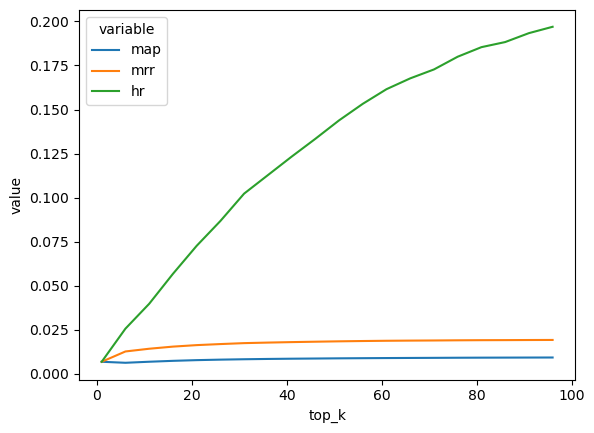

In [58]:
df_w = pd.melt(df_top_k, ['top_k'])
sns.lineplot(data=df_w, x='top_k', y='value', hue='variable')

d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\Programs\anac\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a futur

<Axes: xlabel='top_k', ylabel='value'>

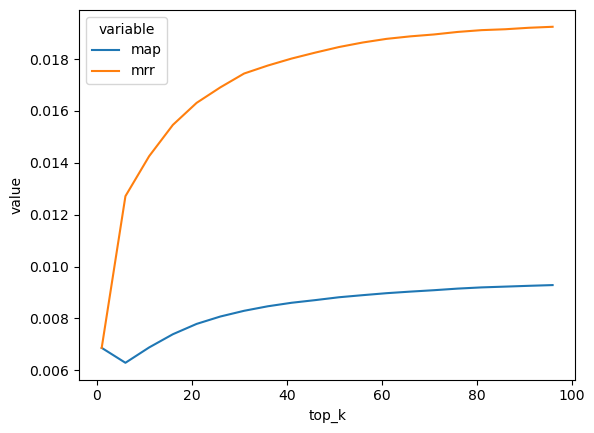

In [59]:
df_w = pd.melt(df_top_k[['top_k', 'map', 'mrr']], ['top_k'])
sns.lineplot(data=df_w, x='top_k', y='value', hue='variable')

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:** Графики соответствую ожиданиям. Чем больше выборка айтемов, тем выше вероятность, что пользователь найдет в ней желаемый айтем.

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций. 

In [60]:
j = joined_f.copy()
w = fit_ease(matrix)

j['ease_r'] = j.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w, 5))

j['name_item'] = j['ease_r'].apply(lambda x: [items[items['item_id']==id]['title'].values[0] for id in x])

print(j['ease_r'])

0         [6686, 6193, 10971, 9214, 8070]
1        [15297, 13865, 4495, 8373, 6192]
2          [142, 9728, 10772, 2657, 4151]
3         [10440, 6443, 7216, 3784, 3768]
4        [142, 12609, 14703, 10569, 9079]
                      ...                
2762       [8101, 2956, 741, 6964, 10939]
2763     [11654, 4946, 8726, 15473, 9370]
2764    [15297, 10440, 12396, 6192, 4495]
2765     [10941, 8337, 10732, 1737, 1785]
2766       [9728, 7102, 7793, 7829, 5287]
Name: ease_r, Length: 2767, dtype: object


In [61]:
j['name_item_test'] = j['test_interactions'].apply(lambda x: [items[items['item_id']==id[0]]['title'].values[0] for id in x])

In [ ]:
j['name_item_train'] = j['train_interactions'].apply(lambda x: [items[items['item_id'] == id[0]]['title'].values[0] for id in x])

In [79]:
j['name_item_train']

0       [[Стукач], [Преступления страсти], [Эвротико 5...
1       [[Любовь или секс], [Стены], [Мосгорсмех], [Де...
2       [[Бояка мухи не обидит], [Солдат Иван Бровкин]...
3       [[Главное – не бояться!], [Северо-Юг], [Кримин...
4       [[Игры джентльменов], [Встреча двух сердец (Ка...
                              ...                        
2762    [[Город 312 - караоке], [Папик (жестовым языко...
2763    [[Пиковая дама], [Белая ночь, нежная ночь], [Т...
2764    [[Бледнолицый лжец], [Пришелец из Сказки], [Зо...
2765    [[Мульт «Кухня»], [], [], [Переполох], [TheBra...
2766    [[Главное – не бояться!], [Эвротико 7], [Москв...
Name: name_item_train, Length: 2767, dtype: object

In [104]:
j.sample(10)

,user_id,train_interactions,test_interactions,ease_r,name_item,name_item_test,name_item_train
1395,150771,"[(1678, 79), (245, 79), (1321, 85), (1191, 86)...","[(14488, 158), (3734, 159)]","[9214, 8070, 5669, 7107, 15428]","[Ржев, Приказ ""Уничтожить"", 28 панфиловцев, Де...","[Мастер меча, Прабабушка легкого поведения]","[[Тихое место], [Парижанка], [Созвездие Сказок..."
1411,151955,"[(371, 10), (1501, 11), (295, 20), (135, 51), ...","[(3363, 154), (1785, 154), (7626, 154), (12360...","[9214, 8070, 7107, 8373, 24]","[Ржев, Приказ ""Уничтожить"", Девятаев, Любовь м...","[Помогите, я уменьшил свою училку!, Чёрная пан...","[[Виктория], [Брачные игры], [Подводная лодка]..."
1042,112852,"[(12, 105), (32, 105), (1963, 106), (920, 106)...","[(16484, 155), (9728, 155), (7793, 155)]","[9896, 8373, 3804, 12501, 146]","[В гостях у Элис, Любовь между строк, Mamma Mi...","[Пила: Начало, Гнев человеческий, Радиовспышка]","[[Ворона-проказница], [В ритме сердца], [Даже ..."
600,67167,"[(1327, 102), (616, 133), (1333, 133), (309, 1...","[(12149, 154), (1046, 158)]","[14809, 5635, 16244, 3474, 6192]","[Красотка, Другая женщина, Предложение (2009),...","[9 рота, Легенда о Красном Орле]","[[Сердцеедки], [Слушай своё сердце], [Мальтийс..."
124,14443,"[(66, 111), (70, 113), (12, 116), (488, 116), ...","[(4583, 162), (10073, 162)]","[4740, 12995, 13865, 9445, 2043]","[Сахаров. Две жизни, Восемь сотен, Девятаев, Л...","[Успеть до полуночи, Джон Уик 3]","[[Три дня на побег], [Мульт «Кухня»], [Ворона-..."
1466,159492,"[(209, 115), (187, 115), (1515, 116), (2028, 1...","[(9506, 157), (7582, 157), (7192, 158), (3541,...","[15297, 3734, 12663, 1042, 11237]","[Клиника счастья, Прабабушка легкого поведения...","[Холодное сердце, Холодное сердце II, Ледников...","[[Общее достояние], [Край Бебис Мэджик Тирс], ..."
971,105378,"[(114, 24), (2126, 24), (803, 24), (107, 24), ...","[(15297, 158), (12615, 158)]","[12743, 3541, 10119, 7192, 9214]","[Ледниковый период 4: Континентальный дрейф, Л...","[Клиника счастья, Вызов]",[[Неизвестная Италия. Матера — город из камня ...
150,18278,"[(260, 1), (233, 54), (791, 84), (2665, 84), (...","[(846, 154), (476, 155), (3554, 156), (4281, 1...","[5635, 3076, 4448, 6143, 1562]","[Другая женщина, Земля кочевников (субтитры), ...","[Новенький, Мир грядущий, Последняя смена, Бол...","[[Прости за любовь], [Белый пудель], [Суходол]..."
2623,287170,"[(12, 105), (70, 105), (54, 149), (682, 149), ...","[(15411, 159), (9718, 161)]","[10942, 7626, 12173, 3940, 9298]","[Мстители, Мстители: Война бесконечности, Мсти...","[Двойник дьявола, Ребекка]","[[Ворона-проказница], [Мульт «Кухня»], [Пинкфо..."
1479,160663,"[(1546, 0), (5060, 1), (3632, 2), (1112, 2), (...","[(5434, 156), (8776, 162), (9728, 162), (14488...","[13545, 13865, 2657, 12995, 598]","[Королевские каникулы, Девятаев, Подслушано, В...","[История семьи Блум, Ещё один мальчишник, Гнев...","[[Схема], [Ограбление века. Пропавшие сокровищ..."


Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:** Рекомендации получились не очень хорошие, но есть пользователи с хорошими: 139961 - юзер смотрел мультфильмы и ему прдложили мультфильм, 26929, 170635 - смотрел Последний богатырь, а ему предложили другую часть Последнего богатыря. Плохие примеры тоже есть - к сожалению, сразу не записала user_id, но было, что пользователь смотрел только русские сериалы, а ему предложили все иностранные, также если человек посмотрел 1 фильм из серии, то в рекомендации может попасться несколько фильмов из нее.
Плохие примеры могут быть, из-за того, что аккаунтом пользуется несколько человек, фатем не очень популярный и алгоритм не может понять какой другой айтем похож на него. Если юзер долгое время смотрел один тип айтемов, то ему будут рекомендовать только их, даже если он начнет смотреть внезапно другие.